# 使用字符级RNN生成姓名

我们仍然使用手工搭建的包含几个线性层的小型RNN。与之前的预测姓名最大的区别是：它不是“阅读”输入的所有字符然后生成一个预测分类，而是输入一个分类然后在每个时间步生成一个字母。循环预测字母来形成一个语言的语句通常被视作**语言模型**。

## 1. 准备数据

>数据下载通道: 点击[这里](https://download.pytorch.org/tutorial/data.zip)下载数据集。解压到当前工作目录。

就和上个预测姓名分类的教程一样，我们有一个姓名文件夹 `data/names/[language].txt` ，每个姓名一行。我们将它转化为一个 array, 转为ASCII字符，最后生成一个字典 `{language: [name1, name2,...]}`

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# 2. 搭建网络

新的网络结果扩充了姓名识别的RNN网络，它的输入增加了一个分类Tensor，该张量同样参与与其他输入的结合(concatenate)。分类张量也是一个one-hot向量。

我们将输出解释为下一个字母的概率。采样时，最可能的输出字母用作下一个输入字母。 

同时，模型增加了第二个线性层(在隐藏层的输出组合之后)，从而增强其性能。后续一个 dropout 层，它随机将输入置0(这里的概率设置为0.1),一般用来模糊输入来达到规避过拟合的问题。在这里，我们将它用于网络的末端，故意添加一些混乱进而增加采样种类。  

网络模型如下所示：
![](https://i.imgur.com/jzVrf7f.png)

In [17]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat([category, input, hidden],dim=1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat([hidden,output],1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 3. 训练

### 3.1 训练准备
首先，辅助函数用来获取(category, line)对

In [7]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

对于每个时间步(训练词语的每个字母)，网络的输入为 `(category, current letter, hidden state)`， 输出为 `(next letter, next hidden state)`。因此对于每个训练集，我们需要一个分类，一个输入字母集合，还有一个目标字母集合。

由于我们需要在每个时间步通过当前字母来预测下一个字母，字母对的形式应该类似于这样，比如 `"ABCD<EOS>"` , 则我们会构建('A','B'),('B','C'),('C','D'),('D','E'),('E','EOS')。  

用图来表示如下：
![](https://i.imgur.com/JH58tXY.png)

分类张量是一个one-hot张量，大小为 `<1 x n_categories>`。在训练的每个时间步我们都将其作为输入。这是众多设计选择的一个，它同样可以作为初始隐藏状态或其他策略的一部分。

In [8]:
# one-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li]=1
    return tensor

# one-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line),1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)]=1
    return tensor

# LongTensor of second letter to end(EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters-1)  # EOS
    return torch.LongTensor(letter_indexes)

方便起见，在训练过程中我们使用`randomTrainingExample` 函数来获取一个随机的 (category, line) 对，然后将其转化为输入要求的 (category, input, target) 张量

In [9]:
# make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 3.2 训练网络
与分类相反，分类仅仅使用最后一层输出，这里我们使用每个时间步的输出作为预测，所以我们需要计算每个时间步的损失

autograd 的魔力使你能够简单的将所有时间步的loss相加，然后在最后反向传播

In [10]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss+=l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

为了跟踪训练时间，这里添加了一个 `timeSince(timestep)`函数，该函数返回一个可读字符串

In [11]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m,s)

训练依旧很花时间-调用训练函数多次，并在每个 `print_every` 样本后打印损失，同时在每个 `plot_every` 样本后保存损失到 `all_losses` 方便后续的可视化损失

In [18]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 17s (5000 5%) 2.1339
0m 34s (10000 10%) 2.3110
0m 53s (15000 15%) 2.2874
1m 13s (20000 20%) 3.5956
1m 33s (25000 25%) 2.4674
1m 52s (30000 30%) 2.3219
2m 9s (35000 35%) 3.0257
2m 27s (40000 40%) 2.5090
2m 45s (45000 45%) 1.9921
3m 4s (50000 50%) 2.0124
3m 22s (55000 55%) 2.8580
3m 41s (60000 60%) 2.4451
3m 59s (65000 65%) 3.1174
4m 16s (70000 70%) 1.7301
4m 34s (75000 75%) 2.9455
4m 52s (80000 80%) 2.3166
5m 9s (85000 85%) 1.2998
5m 27s (90000 90%) 2.1184
5m 45s (95000 95%) 2.6679
6m 3s (100000 100%) 2.4100


### 3.3 打印损失

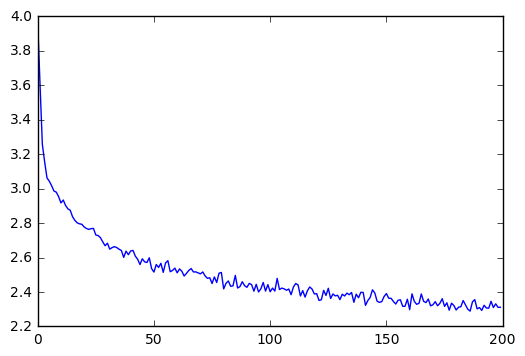

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

## 4. 网络示例

为了示例，我们给网络输入一个字母并询问下一个字母是什么，下一个字母再作为下下个字母的预测输入，直到输出EOS token
- 创建输入分类的Tensor, 初始字母和空的隐藏状态
- 输出 `output_name` ，包含初始的字母
- 最大输出长度,
    - 将当前字母输入网络
    - 获取最大可能输出，和下一个的隐藏状态
    - 如果字母是EOS，则停止
    - 如果是一般字母，则加到`output_name`，继续
- 返回最后的姓名单词

> 另一种策略是不需要给网络决定一个初始字母，而是在训练时包含**字符串开始**标记，并让网络选择自己的初始字母

In [33]:
max_length = 20

# sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad(): # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0],hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name+=letter
            input = inputTensor(letter)
            
        return output_name
    
# get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Irish', 'O')

Ramanovov
Uarin
Shavani
Garen
Eren
Roure
Sangara
Pare
Allan
Ollang
